In [11]:
import multiprocessing
from multiprocessing.pool import ThreadPool
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.problem import StarmapParallelization
from pymoo.constraints.as_obj import ConstraintsAsObjective
from pymoo.constraints.as_penalty import ConstraintsAsPenalty
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.optimize import minimize

import optimize as op

class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=2,
                         n_obj=2,
                         n_ieq_constr=2,
                         xl=np.array([-2,-2]),
                         xu=np.array([2,2]))

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = 100 * (x[0]**2 + x[1]**2)
        f2 = (x[0]-1)**2 + x[1]**2

        g1 = 2*(x[0]-0.1) * (x[0]-0.9) / 0.18
        g2 = - 20*(x[0]-0.4) * (x[0]-0.6) / 4.8

        out["F"] = [f1, f2]
        out["G"] = [g1, g2]


In [12]:
opt = op.corgiOptimize()
opt.L = 0.2
opt.T_sw = 1.2
opt.getLiftoffState()
print("Initial Cost", opt.objective(opt.bp_init_guess))


class CorgiProblem(ElementwiseProblem):

    def __init__(self, **kwargs):
        super().__init__(n_var=24,
                         n_obj=1,
                         n_ieq_constr=24,
                         xl=np.array([0.33, 0.00, 0.01, -0.05, 0.01, -0.05,
                                      0.33, 0.00, 0.01, -0.05, 0.01, -0.05,
                                      0.33, 0.00, 0.01, -0.05, 0.01, -0.05,
                                      0.33, 0.00, 0.01, -0.05, 0.01, -0.05]),
                         xu=np.array([0.35, 0.02, 0.5, 0.5, 0.5, 0.5,
                                      0.35, 0.02, 0.5, 0.5, 0.5, 0.5,
                                      0.35, 0.02, 0.5, 0.5, 0.5, 0.5,
                                      0.35, 0.02, 0.5, 0.5, 0.5, 0.5]),
                         **kwargs)

    def _evaluate(self, x, out, *args, **kwargs):
        f  = opt.objective(x)

        g1 = -1 * opt.innerWsPFConstraint(x)
        g2 = -1 * opt.outerWsPFConstraint(x)
        g3 = np.abs(opt.velocityConstraint(x)) - 0.01
        print("g3", np.average(g3))
        g = np.hstack((g1, g2))
        g = np.hstack((g, g3))

        out["F"] = [f]
        out["G"] = list(g)

# initialize the thread pool and create the runner
# n_proccess = 8
# pool = multiprocessing.Pool(n_proccess)
# runner = StarmapParallelization(pool.starmap)

# initialize the thread pool and create the runner
n_threads = 16
pool = ThreadPool(n_threads)
runner = StarmapParallelization(pool.starmap)
problem = CorgiProblem(elementwise_runner=runner, elementwise_evaluation=True)
# problem = CorgiProblem()


[0.05 0.01 0.1  0.01 0.1  0.01]
[0.05 0.01 0.1  0.01 0.1  0.01]
[0.05 0.01 0.1  0.01 0.1  0.01]
[0.05 0.01 0.1  0.01 0.1  0.01]
iter 1 cost -4.751466554883699
Initial Cost -4.751466554883699


In [13]:
algorithm = NSGA2(
    pop_size=60,
    n_offsprings=30,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)
# algorithm = PSO()

In [14]:
from pymoo.termination import get_termination

termination = get_termination("n_gen", 100)

In [15]:

result = minimize(ConstraintsAsPenalty(problem, 5),
                  algorithm,
                  termination,
                  seed=1,
                  save_history=False,
                  verbose=False)

# result = minimize(ConstraintsAsObjective(problem),
#                   algorithm,
#                   seed=1,
#                   save_history=True,
#                   verbose=True)


pool.close()


[0.33834044 0.01440649 0.01005604 0.11628291 0.08191039 0.00078623]
[0.3337252  0.00691121 0.20441606 0.2463492  0.21540531 0.32687073]
[0.33408904 0.01756235 0.02341992 0.31875713 0.21447935 0.25727941]
[0.33280774 0.00396203 0.40236484 0.48254387 0.16357785 0.33077744]
[ 0.34752778  0.01789213  0.05167166 -0.02851987  0.09321691  0.43297838]
[0.33196694 0.00842215 0.47936587 0.24324091 0.34901979 0.1235336 ]
[0.34373002 0.01669251 0.01896126 0.36257937 0.49454193 0.36149111]
[0.33560888 0.01578559 0.06058074 0.19634144 0.4552118  0.11148778]
[0.33575551 0.00260057 0.01948981 0.32335954 0.11369778 0.09605066]
[0.33983146 0.00106725 0.29131763 0.03070072 0.29875971 0.3348671 ]
[0.33204669 0.00828112 0.35025608 0.1777986  0.03447719 0.24474302]
[0.34327589 0.01029778 0.47285143 0.27260527 0.45266694 0.02561109]
[0.33278553 0.01614783 0.20486165 0.04094481 0.4644792  0.14127122]
[0.34501624 0.01451996 0.44281998 0.29301971 0.37796179 0.14189409]
[0.33539856 0.01791772 0.21976468 0.480662

[ 3.30006405e-01  6.59720236e-04  1.01606488e-02 -4.99796316e-02
  5.18519322e-01  2.65419398e-01  3.30053201e-01  3.52854355e-06
  8.45648493e-01  1.31960784e-01  1.04387373e-02 -4.99425627e-02
  3.30099859e-01  5.31547902e-04  1.89945025e-01  6.62583203e-02
  1.11526245e-02 -4.88935811e-02  3.30003573e-01  9.14015206e-05
  3.11665141e-01  1.50389994e-01  1.04592347e-02 -4.78668758e-02]
[87.83154886]
---
Optimized Bezier Profile:
[[ 3.30006405e-01  6.59720236e-04  1.01606488e-02 -4.99796316e-02
   5.18519322e-01  2.65419398e-01]
 [ 3.30053201e-01  3.52854355e-06  8.45648493e-01  1.31960784e-01
   1.04387373e-02 -4.99425627e-02]
 [ 3.30099859e-01  5.31547902e-04  1.89945025e-01  6.62583203e-02
   1.11526245e-02 -4.88935811e-02]
 [ 3.30003573e-01  9.14015206e-05  3.11665141e-01  1.50389994e-01
   1.04592347e-02 -4.78668758e-02]]


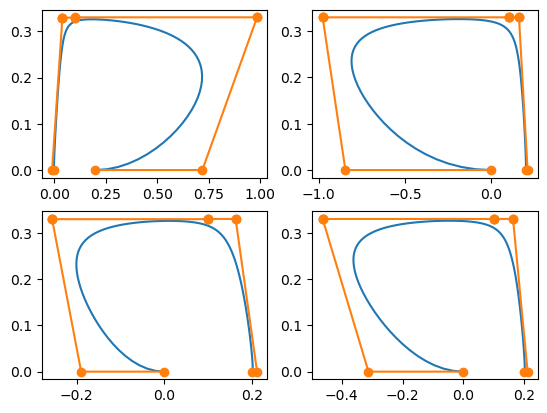

In [ ]:
print(result.X)
print(result.F)
min_ = np.min(result.F, axis=0)

opt.plotResult(result.X)

In [ ]:
# print(result.pop.get("X"))
bp = np.array([0.034815,    0.00341456,  0.01004385, -0.03486108,  0.02724615, -0.08330442,
 0.03140377,  0.00436724,  0.01425195, -0.03556327,  0.02642443, -0.09868557,
 0.03100124,  0.0039261,   0.02582531, -0.02476453,  0.01291202, -0.04367011,
 0.03027373,  0.00167466,  0.0149596,  -0.03968913,  0.02813969, -0.09163613])

bp = np.array([ 3.90475000e-02,  1.26541517e-02,  1.29990659e-02,
        -9.43200192e-02,  5.01530731e-02, -8.84345508e-02,
         3.14253998e-02,  6.60885379e-03,  1.64677686e-01,
        -7.29851060e-02,  4.03009612e-02, -5.70694902e-02,
         3.10178224e-02,  1.41883854e-02,  2.16441144e-02,
         3.29020311e-02,  1.51452422e-02, -9.34873236e-02,
         3.01523820e-02,  1.95010099e-03,  4.55182621e-02,
        -9.75865250e-02,  2.84592035e-02, -5.60758920e-02])
# opt.exportBezierData(bp)
opt.exportBezierData(result.X)

# candidate
# L 0.2 T 0.6
#4
#6
#8
# L 0.15 T 0.3

data export
sbrio exported to ./csv_trajectory/20230828/2023-08-30_traj_400_4.csv
data export
webot exported /home/guanlunlu/corgi_webots/controllers/supervisor/2023-08-30_traj_400_4.csv


In [ ]:
opt = op.corgiOptimize()
opt.L = 0.2
opt.T_sw = 0.6
opt.getLiftoffState()
print("Initial Cost", opt.objective(result.X))

[ 0.33000641  0.00065972  0.01016065 -0.04997963  0.51851932  0.2654194 ]
[ 3.30053201e-01  3.52854355e-06  8.45648493e-01  1.31960784e-01
  1.04387373e-02 -4.99425627e-02]
[ 0.33009986  0.00053155  0.18994503  0.06625832  0.01115262 -0.04889358]
[ 3.30003573e-01  9.14015206e-05  3.11665141e-01  1.50389994e-01
  1.04592347e-02 -4.78668758e-02]
iter 1 cost 73.72786549005278
Initial Cost 73.72786549005278
